# Face Recognition with Raspberry Pi
Prof. Yonggang Wen, TA: Huaizheng Zhang, Weizheng HU

## Part_1 Prepare your training images
In the first part, you need to transform your training images by using different methods like rotate, crop and so on so that you can have more images to train your model and make your model more robust.  The processing is called data augmentation. For example, if you only use front face to train, when the camera just detects a part of face it may not recognize it).


In [1]:
import numpy as np
import cv2
import os
import keras
import h5py
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
import keras.backend as K
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Let's see what is data augmentation

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1309x1742 at 0x7FE51B4D3F50>
(1742, 1309, 3)
(1, 1742, 1309, 3)


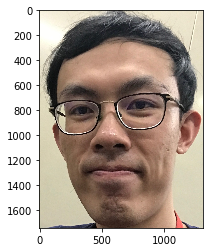

In [2]:
img = load_img('face_data/ZhangHuaizheng/ZhangHuaizheng003.jpeg')  # this is a PIL image
print img
imshow(img)
test_1 = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
print test_1.shape
test_1 = test_1.reshape((1, ) + test_1.shape) # this is a Numpy array with shape (1, 3, 150, 150)
print test_1.shape

#### Process all face images.

In [4]:
NAME = ['ZhouXin', 'YiDeliang', 'WangYongjie', 'ZhangHuaizheng', 'LuoYong']
datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=0.5,
        fill_mode='nearest')
  

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `aug_data/` directory
for name in NAME:
    for number in range(1, 6):
        temp = load_img('face_data/' + name + '/' + name + '00' + str(number) + '.jpeg')
        img_arr = img_to_array(temp)
        img_arr = img_arr.reshape((1, ) + img_arr.shape)
        i = 0
        for batch in datagen.flow(img_arr, batch_size=1,
                                  save_to_dir='aug_data/'+ name, save_prefix=name + str(number), save_format='jpeg'):
            i += 1
            if i > 99:
                break

## Part_2 Build your deep learning model to recognize people

In [2]:
def model(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(32, (3, 3), )(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Conv2D(32, (3, 3), )(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Conv2D(64, (3, 3), )(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Flatten()(X)
    X = Dense(64)(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(5)(X)
    X = Activation('softmax')(X)
    
    model = Model(inputs=X_input, outputs=X, name='FaceModel')
    
    return model

#### Creat and compile your model to prepare to train

In [6]:
FaceModel = model((48, 48, 3))
FaceModel.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
FaceModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 21, 21, 32)        128       
__________

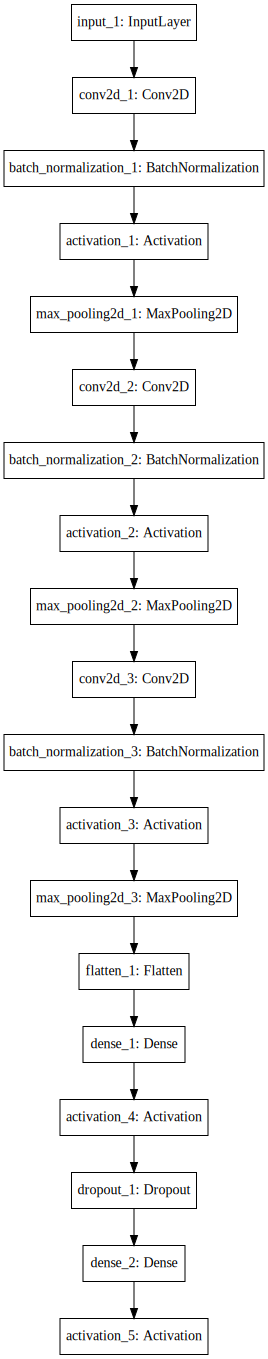

In [8]:
SVG(model_to_dot(FaceModel).create(prog='dot', format='svg'))

## Part_3 Train you model

#### Prepare your data and split them to training set and validation set

In [12]:
img_paths = []
for i in os.listdir('aug_data'):
    j = os.listdir(os.path.join('aug_data', i))
    for k in j:
        img_paths.append(os.path.join('aug_data', i, k))
        
print img_paths

['aug_data/val/ZhangHuaizheng', 'aug_data/val/ZhouXin', 'aug_data/val/LuoYong', 'aug_data/val/YiDeliang', 'aug_data/val/WangYongjie', 'aug_data/train/ZhangHuaizheng', 'aug_data/train/ZhouXin', 'aug_data/train/LuoYong', 'aug_data/train/YiDeliang', 'aug_data/train/WangYongjie']


In [7]:
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('aug_data/train/',
                                                   target_size=(48, 48),
                                                   batch_size=batch_size,
                                                   class_mode = 'categorical')
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory('aug_data/val/',
                                                   target_size=(48, 48),
                                                   batch_size=batch_size,
                                                   class_mode = 'categorical')


Found 2236 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [8]:
FaceModel.fit_generator(
        train_generator,
        steps_per_epoch=2236 // batch_size,
        epochs=50,
        validation_data=val_generator,
        validation_steps=100 // batch_size)

model_json = FaceModel.to_json()
with open("face_model_4.json", "w") as json_file:
    json_file.write(model_json)
FaceModel.save_weights('face_model_4.h5')

Epoch 1/50
69/69 [==============================] - 45s 646ms/step - loss: 1.4370 - acc: 0.3837 - val_loss: 1.7869 - val_acc: 0.1979
Epoch 2/50
69/69 [==============================] - 44s 635ms/step - loss: 1.0650 - acc: 0.5575 - val_loss: 2.4279 - val_acc: 0.2396
Epoch 3/50
69/69 [==============================] - 43s 627ms/step - loss: 0.8056 - acc: 0.6748 - val_loss: 2.9631 - val_acc: 0.2708
Epoch 4/50
69/69 [==============================] - 43s 619ms/step - loss: 0.6115 - acc: 0.7591 - val_loss: 3.4031 - val_acc: 0.3750
Epoch 5/50
69/69 [==============================] - 42s 612ms/step - loss: 0.4589 - acc: 0.8250 - val_loss: 3.6403 - val_acc: 0.3750
Epoch 6/50
69/69 [==============================] - 41s 600ms/step - loss: 0.3865 - acc: 0.8551 - val_loss: 3.4631 - val_acc: 0.4167
Epoch 7/50
69/69 [==============================] - 41s 597ms/step - loss: 0.3010 - acc: 0.8958 - val_loss: 2.4515 - val_acc: 0.5208
Epoch 8/50
69/69 [==============================] - 40s 582ms/step - 

## Part_4 Deploy your model to Raspberry Pi3

#### Notice: You should deploy this part to your Raspberry Pi. (Some codes may need to be revised.)

#### Start to use Pi camera

In [17]:
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from keras.models import model_from_json
import time

#### Load pre-trained model

In [18]:
with open('face_model_3.json', 'rb') as json_file:
    model_json = json_file.read()
    
model = model_from_json(model_json)
model.load_weights('face_model_3.h5')
print "Load model successfully"


Load model successfully


#### Turn on the Pi camera

In [19]:
print "Start video stream"
camera = PiCamera()
camera.resolution = (320,240)
camera.framerate = 32
cap = PiRGBArray(camera, size=(320,240))

Start video stream


ImportError: No module named picamera.array

#### Get frame and start to predict

In [15]:
THD = 0.7
for i in camera.capture_continuous(cap, format='bgr', use_video_port=True):
    frame = i.array
    
    image = cv2.resize(frame, (150, 150))
    image = image.astype('float') / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    predict = model.predict(image)[0]
    
    if predict[0] > THD:
        frame = cv2.putText(frame, "Hello, Dr.Luo Yong", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    elif predict[1] > THD:
        frame = cv2.putText(frame, "Hello, Wang Yongjie", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    elif predict[2] > THD:
        frame = cv2.putText(frame, "Hello, Yi Deliang", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    elif predict[3] > THD:
        frame = cv2.putText(frame, "Hello, Zhang Huaizheng", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    elif predict[4] > THD:
        frame = cv2.putText(frame, "Hello, Dr.Zhou Xin", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    else:
        frame = cv2.putText(frame, "Can not recognize", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    cap.truncate(0)
    
    if key == ord('q'):
        break
        
# print "cleaing up"
# cv2.destroyAllWindows()
    

AttributeError: 'NoneType' object has no attribute 'shape'

## Optional_Part Detect the face from your training image
After the first step, we have many training images now. We want to implement a face recognition system so we need to do face detection first. Then we extract the face from the image and use this face to train our recognition model. The detection algorithm called LBP which is very fast. If you want to know more details about it you can check the reference.

In [ ]:
def detect_face(image_dir, classifier):
    allfile = [f for f in os.listdir(path)]

In [4]:
face_cascade = cv2.CascadeClassifier('opencv/data/haarcascades/haarcascade_frontalface_default.xml')
lbp_face_cascade = cv2.CascadeClassifier('opencv/data/lbpcascades/lbpcascade_frontalface.xml')  

In [24]:
def thresholded(center, pixels):
    out = []
    for a in pixels:
        if a >= center:
            out.append(1)
        else:
            out.append(0)
    return out


def get_pixel_else_0(l, idx, idy, default=0):
    try:
        return l[idx, idy]
    except IndexError:
        return default

[[299  75 246 246]]


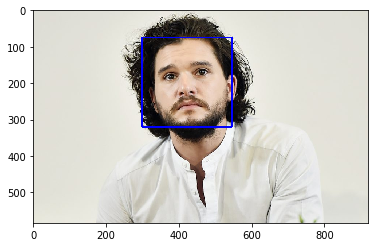

In [15]:
img = cv2.imread('face_data/3.jpg')
newgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

face = lbp_face_cascade.detectMultiScale(newgray,
                                    scaleFactor=1.1,
                                    minNeighbors=5,
                                    minSize=(30, 30),
                                    )
for (x, y, w, h) in face:
#    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),3)
    roi_gray = newgray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
print face

### Reference
1. Building powerful image classification models using very little data.
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
2. realtime face recognition with deep learning in python. https://github.com/Minalinskyy/face-recognition-with-deep-learning-python
3. Keras and deep learning on the Raspberry Pi https://www.pyimagesearch.com/2017/12/18/keras-deep-learning-raspberry-pi/